In [1]:
import pandas as pd
import numpy as np
import nmslib

%load_ext autoreload
%autoreload 2
from matrix_factorization import Matrix_Factorization_V2

from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -200.

# VBD DATA

In [3]:
beacons = ['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006']

def preprocess_data(raw_data='training-vbd-floor3.json', beacons=beacons):
    rawdata_vbd_df = pd.read_json(raw_data)
    data = []
    row_data = []
    for cell in rawdata_vbd_df.data.beacons:
        row_data = []
        row_data.append(cell['Y'])
        row_data.append(cell['X'])
        for beacon in beacons:
            row_data.append(int(cell[beacon]))
        # drop 
        if OUT_OF_RANGE_RSSI in row_data:
            continue
        data.append(row_data)
    columns = ['col', 'row'] + beacons
    # convert to dataframe
    rssi_dataset_df = pd.DataFrame(data, columns=columns)
    return rssi_dataset_df

# convert to dataframe
rssi_dataset_df = preprocess_data()

## Split train set & test set

In [9]:
training_data = rssi_dataset_df.sample(frac=0.9, random_state=10)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 186
No. of testing examples: 21


# Gaussian Processes Regression

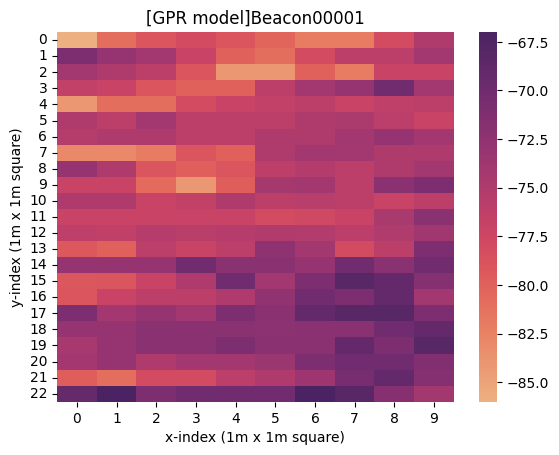

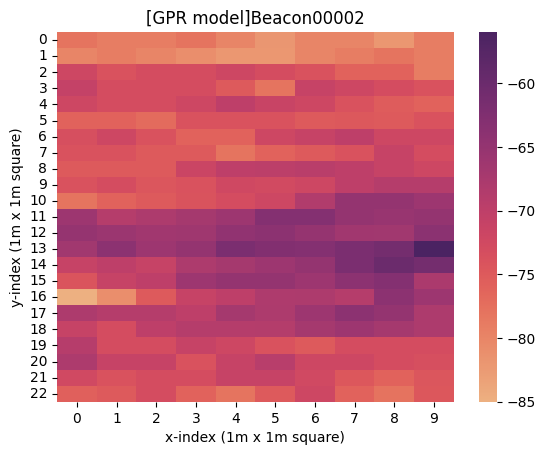

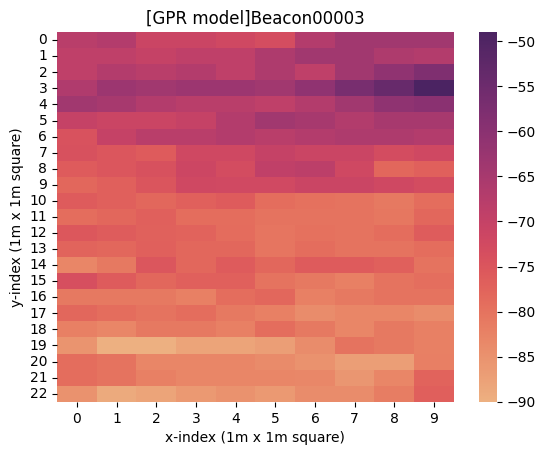

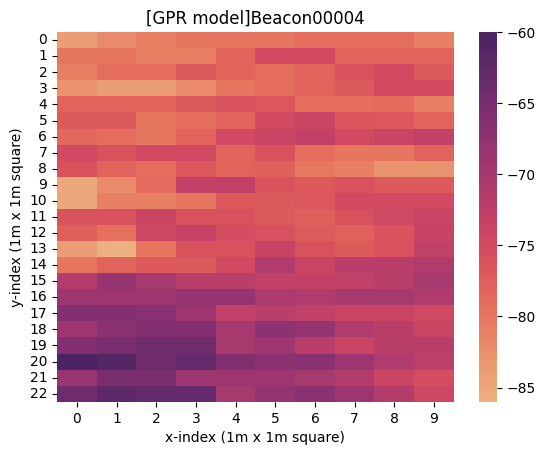

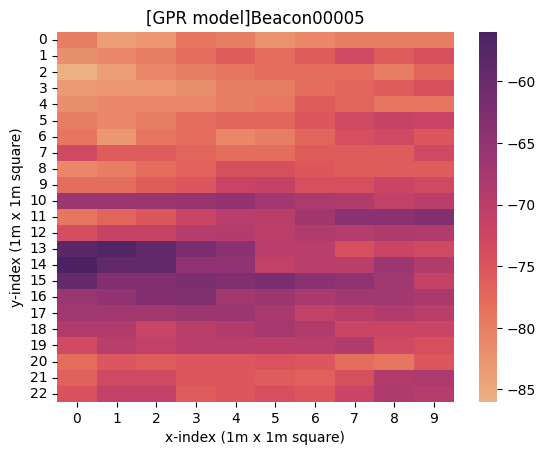

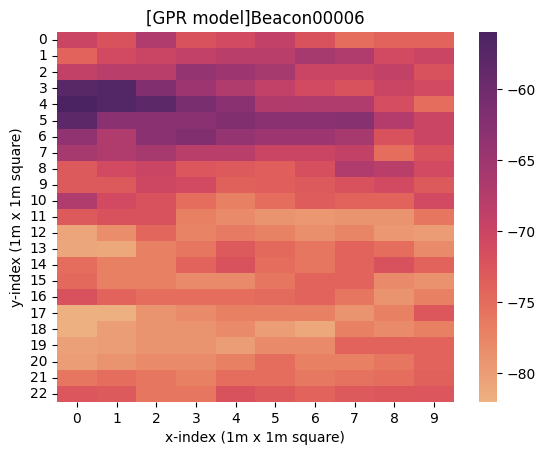

In [10]:
from helper import plot_radiomap

# init test matrix
n_rows = int(rssi_dataset_df.describe()['row']['max'])+1
n_cols = int(rssi_dataset_df.describe()['col']['max'])+1
radiomap = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomaps = []
radiomaps_test = []
for beacon in beacons:
    # sample inputs and outputs
    X = training_data[['row', 'col']].to_numpy()
    Y = training_data[[beacon]].to_numpy()

    # standardscale
    X_scaler = preprocessing.StandardScaler().fit(X)
    Y_scaler = preprocessing.StandardScaler().fit(Y)
    # transform
    X_scaled = X_scaler.transform(X)
    Y_scaled = Y_scaler.transform(Y)

    # init kernel
    kernel = k.RBF(length_scale=[1., 1.], length_scale_bounds=(1e-2,1e2))
    # run GPR
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=True)
    gp.fit(X_scaled, Y_scaled.reshape(-1,1))

    # PLOT
    for i in range(n_rows):
        for j in range(n_cols):
            x_pred = X_scaler.transform(np.array([[i,j]]))
            y_mean,y_std = gp.predict(x_pred,return_std=True)
            radiomap[i, j] = Y_scaler.inverse_transform(np.array([y_mean]))
    plot_radiomap(radiomap, min_data=radiomap.min(), max_data=radiomap.max(), beacon=beacon)
    # [END] PLOT

    # add radiomap
    radiomaps.append(radiomap.flatten())


In [11]:
import helper

Test data (22,0): [-66 -77 -92 -60 -72 -76]
Test coord [106.66883929  10.81069191]
3 nearest neighbours (array idx): [221 222 223] [28. 67. 78.]
3 nearest neighbours (matrix idx):
([[22  1]
 [22  2]
 [22  3]])
Centroid cell: ([22.50000065  2.1392419 ])
Centroid coord: ([106.66885127  10.81069658])
Error: 1.6392419031217076


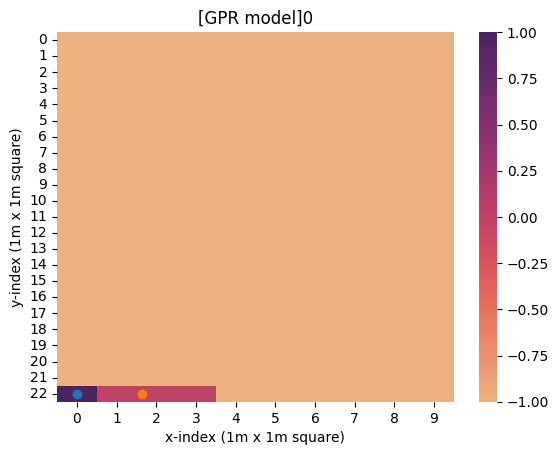

Test data (22,8): [-68 -74 -86 -69 -72 -71]
Test coord [106.66889776  10.81071474]
3 nearest neighbours (array idx): [227 225 226] [12. 14. 31.]
3 nearest neighbours (matrix idx):
([[22  7]
 [22  5]
 [22  6]])
Centroid cell: ([22.5         6.56365503])
Centroid coord: ([106.66888361  10.81070921])
Error: 1.9363449745982253


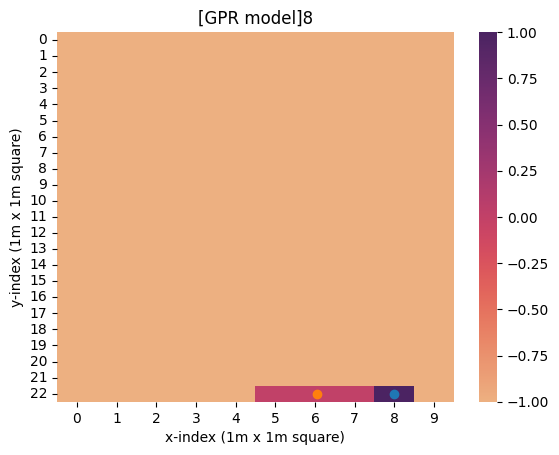

Test data (21,0): [-87 -72 -80 -66 -74 -75]
Test coord [106.66883663  10.8106988 ]
3 nearest neighbours (array idx): [211 210 212] [42.      65.94123 89.     ]
3 nearest neighbours (matrix idx):
([[21  1]
 [21  0]
 [21  2]])
Centroid cell: ([21.5         1.42174816])
Centroid coord: ([106.66884337  10.81070143])
Error: 0.9217481639716882


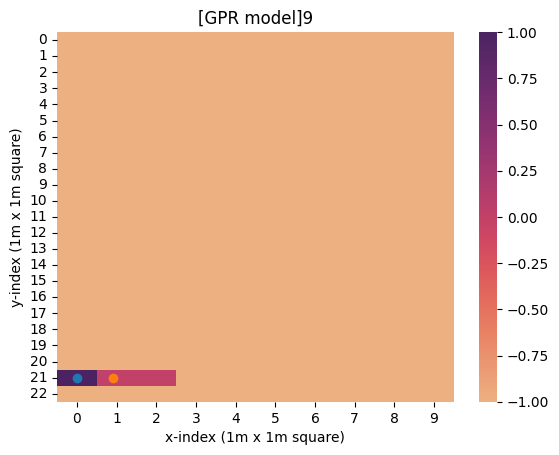

Test data (21,6): [-76 -74 -82 -71 -72 -73]
Test coord [106.66888051  10.81071589]
3 nearest neighbours (array idx): [214 198 213] [27. 30. 35.]
3 nearest neighbours (matrix idx):
([[21  4]
 [19  8]
 [21  3]])
Centroid cell: ([20.82620281  5.55882348])
Centroid coord: ([106.66887184  10.81071783])
Error: 1.157504169244544


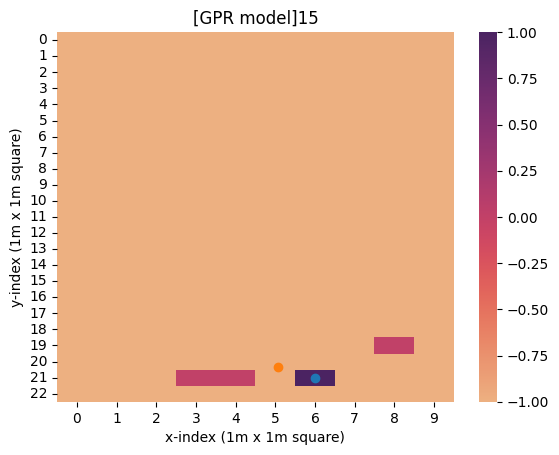

Test data (21,7): [-74 -73 -84 -71 -71 -74]
Test coord [106.66888782  10.81071874]
3 nearest neighbours (array idx): [198 196 217] [23.       26.       28.914928]
3 nearest neighbours (matrix idx):
([[19  8]
 [19  6]
 [21  7]])
Centroid cell: ([20.09359866  7.54305334])
Centroid coord: ([106.66888443  10.8107285 ])
Error: 1.4070601677253922


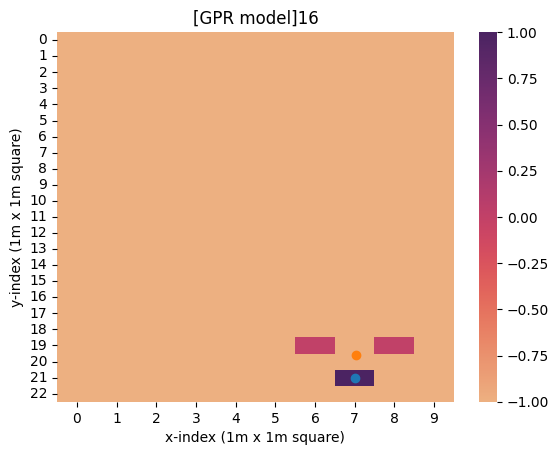

Test data (18,5): [-71 -68 -84 -68 -67 -80]
Test coord [106.66886527  10.81073364]
3 nearest neighbours (array idx): [186 184 172] [16. 18. 23.]
3 nearest neighbours (matrix idx):
([[18  6]
 [18  4]
 [17  2]])
Centroid cell: ([18.23084112  4.73551401])
Centroid coord: ([106.66885896  10.81073332])
Error: 0.8104846310418797


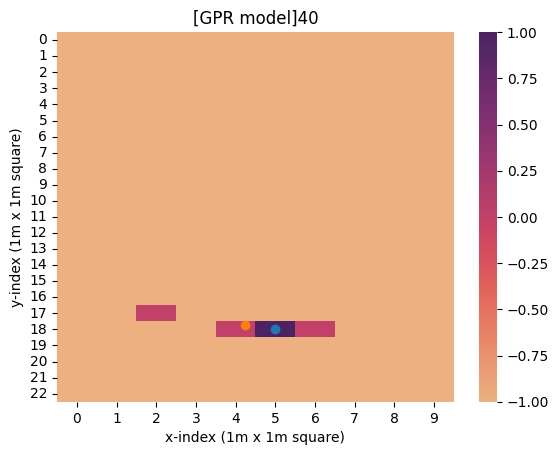

Test data (17,9): [-69 -65 -83 -71 -69 -76]
Test coord [106.66889195  10.8107518 ]
3 nearest neighbours (array idx): [178 176 166] [11. 11. 16.]
3 nearest neighbours (matrix idx):
([[17  8]
 [17  6]
 [16  6]])
Centroid cell: ([17.24418605  7.24418605])
Centroid coord: ([106.66887474  10.81074718])
Error: 2.2702725261634193


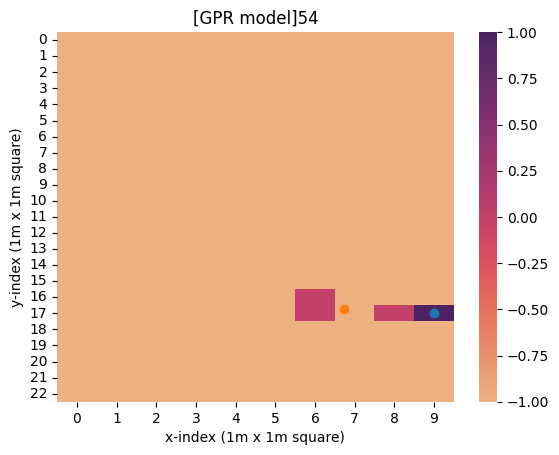

Test data (15,0): [-79 -70 -75 -69 -65 -79]
Test coord [106.66882065  10.81074018]
3 nearest neighbours (array idx): [151 152 173] [11. 22. 43.]
3 nearest neighbours (matrix idx):
([[15  1]
 [15  2]
 [17  3]])
Centroid cell: ([15.79139108  2.07615897])
Centroid coord: ([106.66883299  10.8107426 ])
Error: 1.602868010532806


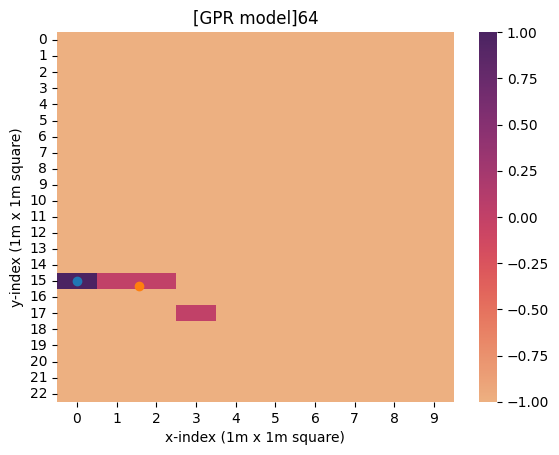

Test data (15,9): [-73 -61 -79 -71 -68 -79]
Test coord [106.6688867   10.81076548]
3 nearest neighbours (array idx): [158 129 168] [24.      25.39703 28.     ]
3 nearest neighbours (matrix idx):
([[15  8]
 [12  9]
 [16  8]])
Centroid cell: ([14.79416935  8.83724037])
Centroid coord: ([106.66887998  10.81076845])
Error: 0.9682185942929724


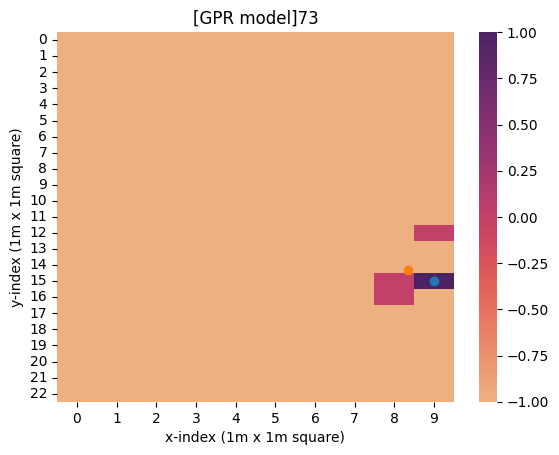

Test data (13,5): [-74 -60 -78 -77 -68 -71]
Test coord [106.66885206  10.81076796]
3 nearest neighbours (array idx): [134 148 136] [29. 35. 40.]
3 nearest neighbours (matrix idx):
([[13  4]
 [14  8]
 [13  6]])
Centroid cell: ([13.82447552  6.36573427])
Centroid coord: ([106.66885928  10.81076816])
Error: 0.9245432372030793


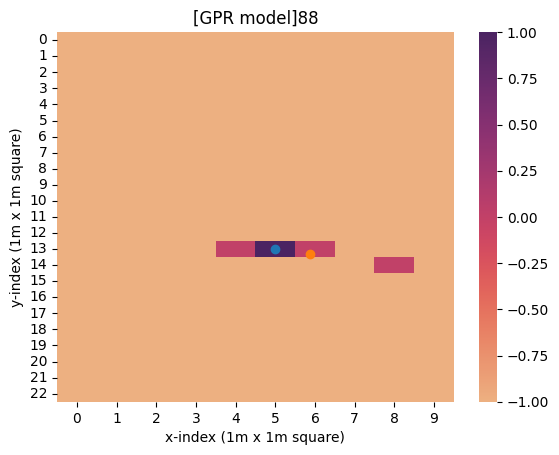

Test data (11,8): [-76 -65 -78 -77 -63 -80]
Test coord [106.66886884  10.81079006]
3 nearest neighbours (array idx): [117 118 133] [ 8.       16.882391 19.      ]
3 nearest neighbours (matrix idx):
([[11  7]
 [11  8]
 [13  3]])
Centroid cell: ([11.94440169  6.86126878])
Centroid coord: ([106.66885796  10.81078244])
Error: 1.6979201559356039


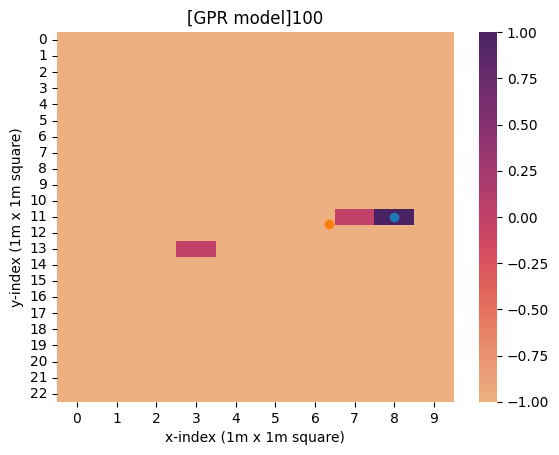

Test data (10,6): [-75 -66 -77 -78 -69 -74]
Test coord [106.66885149  10.81079134]
3 nearest neighbours (array idx): [106 124 107] [17.057901 19.67984  20.      ]
3 nearest neighbours (matrix idx):
([[10  6]
 [12  4]
 [10  7]])
Centroid cell: ([11.13740929  6.17619327])
Centroid coord: ([106.66885079  10.81078607])
Error: 0.7149415352794037


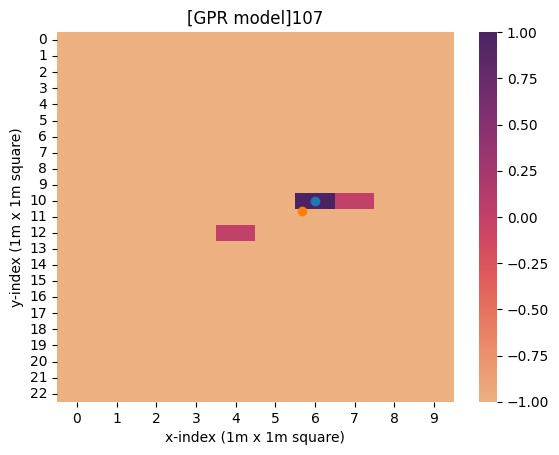

Test data (9,2): [-82 -72 -75 -78 -75 -71]
Test coord [106.6688194  10.8107871]
3 nearest neighbours (array idx): [92 84 83] [ 9.860899 22.       24.18984 ]
3 nearest neighbours (matrix idx):
([[9 2]
 [8 4]
 [8 3]])
Centroid cell: ([9.03883097 3.20268514])
Centroid coord: ([106.66882335  10.81079222])
Error: 0.8405018047078171


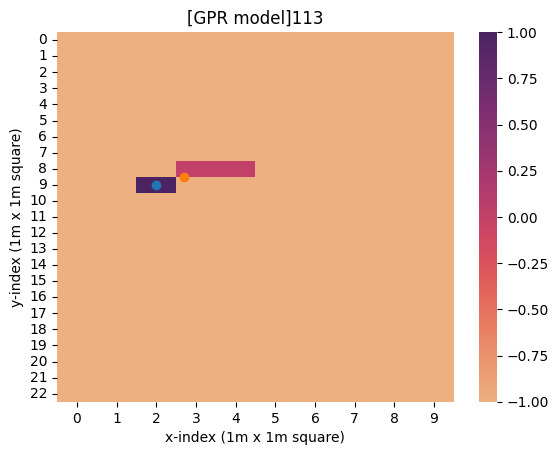

Test data (9,5): [-77 -75 -72 -75 -74 -70]
Test coord [106.66884149  10.81079543]
3 nearest neighbours (array idx): [73 79 75] [17. 22. 26.]
3 nearest neighbours (matrix idx):
([[7 3]
 [7 9]
 [7 5]])
Centroid cell: ([7.50000037 5.94956803])
Centroid coord: ([106.66883952  10.8108104 ])
Error: 2.0499048648591716


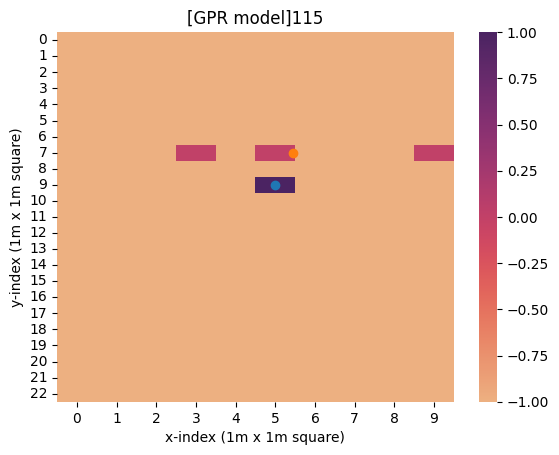

Test data (8,3): [-78 -71 -74 -78 -78 -69]
Test coord [106.66882411  10.81079675]
3 nearest neighbours (array idx): [82 83 92] [19.       25.725729 25.778456]
3 nearest neighbours (matrix idx):
([[8 2]
 [8 3]
 [9 2]])
Centroid cell: ([8.79772399 2.79833453])
Centroid coord: ([106.66881973  10.81079276])
Error: 0.7622165126164823


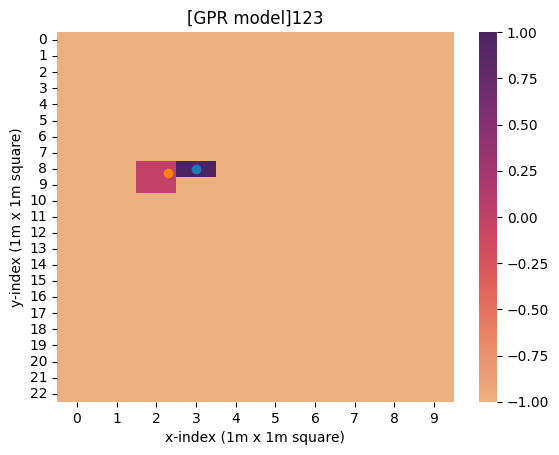

Test data (8,5): [-77 -70 -74 -77 -75 -73]
Test coord [106.66883885  10.81080229]
3 nearest neighbours (array idx): [84 97 78] [ 7. 13. 20.]
3 nearest neighbours (matrix idx):
([[8 4]
 [9 7]
 [7 8]])
Centroid cell: ([8.59979578 6.09674094])
Centroid coord: ([106.66884351  10.81080326])
Error: 0.6050280561967711


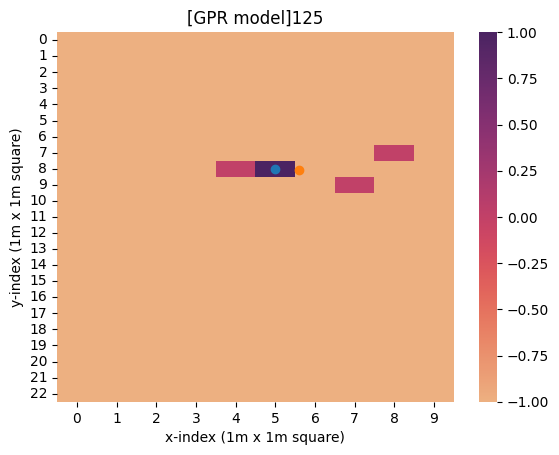

Test data (6,0): [-72 -72 -68 -80 -86 -69]
Test coord [106.66879668  10.81080224]
3 nearest neighbours (array idx): [20 21 61] [ 6. 20. 27.]
3 nearest neighbours (matrix idx):
([[2 0]
 [2 1]
 [6 1]])
Centroid cell: ([3.08394156 0.84306568])
Centroid coord: ([106.66879012  10.81082673])
Error: 3.4332418120100616


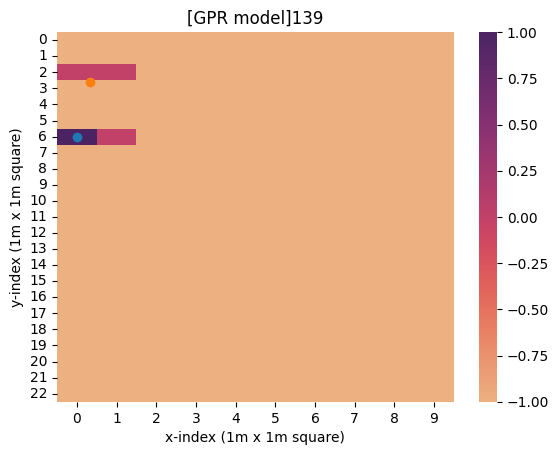

Test data (5,7): [-75 -74 -64 -74 -70 -67]
Test coord [106.66884569  10.81082839]
3 nearest neighbours (array idx): [58 59 67] [11.558159 34.       39.      ]
3 nearest neighbours (matrix idx):
([[5 8]
 [5 9]
 [6 7]])
Centroid cell: ([5.68111694 8.52663503])
Centroid coord: ([106.66885374  10.81082997])
Error: 1.0424887723608032


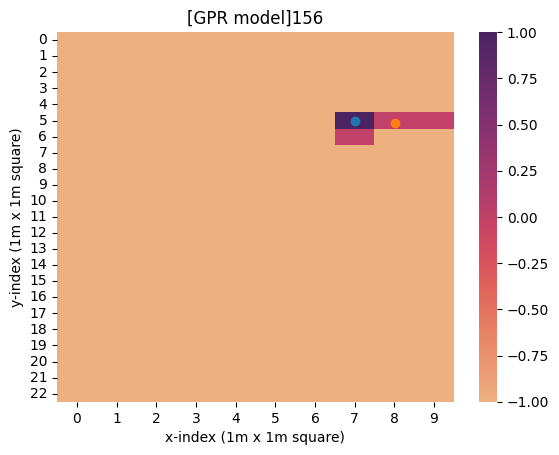

Test data (5,8): [-76 -75 -66 -78 -71 -67]
Test coord [106.66885307  10.81083114]
3 nearest neighbours (array idx): [58 59 17] [ 3.7106864 13.        24.       ]
3 nearest neighbours (matrix idx):
([[5 8]
 [5 9]
 [1 7]])
Centroid cell: ([5.07053733 8.59084831])
Centroid coord: ([106.66885261  10.81083433])
Error: 0.438966516843838


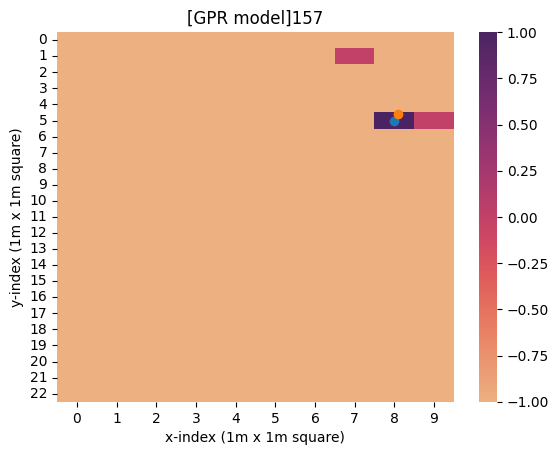

Test data (4,5): [-79 -72 -72 -78 -79 -64]
Test coord [106.66882828  10.81082975]
3 nearest neighbours (array idx): [60 53 23] [19.566702 20.       28.      ]
3 nearest neighbours (matrix idx):
([[6 0]
 [5 3]
 [2 3]])
Centroid cell: ([5.09044712 2.37940361])
Centroid coord: ([106.6688068   10.81081712])
Error: 3.175964366947681


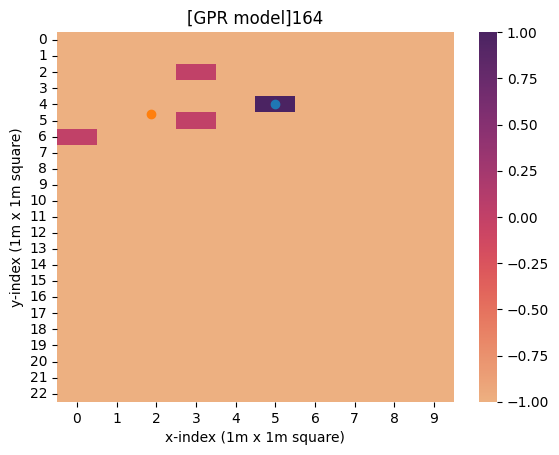

Test data (0,5): [-80 -79 -70 -82 -80 -69]
Test coord [106.66881772  10.81085721]
3 nearest neighbours (array idx): [ 4  2 13] [14. 16. 19.]
3 nearest neighbours (matrix idx):
([[0 4]
 [0 2]
 [1 3]])
Centroid cell: ([0.78211587 3.54785896])
Centroid coord: ([106.66880401  10.81084996])
Error: 1.9724208497474858


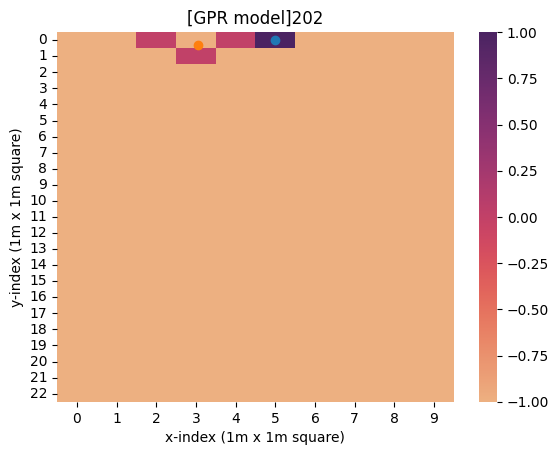

RMSE:  1.6485450101768369


In [14]:
bounds = np.array([
    [106.66877566527455, 10.810845700675742],
    [106.66884972115128, 10.810872873012372],
    [106.66891003308865, 10.810715599882684],
    [106.66883697216787, 10.810687029981409]
    ])
helper.check_position_pred_accuracy(n_rows=n_rows, n_cols=n_cols,radiomaps=radiomaps, testing_data=testing_data, bounds=bounds)